# Biblioteca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
from datetime import datetime, timedelta, date

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## tirar os warnings nao eh uma boa pratica, mas como os avisos ja foram mapeados
## optou-se por retira-los pra manter o codigo mais limpo e coeso
import warnings 
warnings.filterwarnings("ignore")

# Funcoes

In [2]:
def moving_average_test(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0] -20):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).mean()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error


def moving_average_test2(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0]):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).mean()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error


# Acessando arquivos


In [3]:
clusters = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/clusters_18medoids.xlsx')
dict_ = {}
for dic in range((clusters.shape[0])):
    # print(dic)
    dict_[clusters['clusters'][dic]] = clusters['medoids'][dic]
# dict_

In [4]:
# abrindo arquivos
viagens_validas = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/matriz_junho_mapeada.xlsx', index_col='Unnamed: 0')

#renomeia colunas
viagens_validas.columns = ['index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'latitudeI', 'longitudeI',
       'latitudeF', 'longitudeF', 'Nome_PontoI', 'Nome_PontoF', 'PontoFinal',
       'dist_PontoF', 'PontoInicial', 'dist_PontoI']

# reordena colunas
viagens_validas = viagens_validas[[  'index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'PontoInicial','Nome_PontoI','latitudeI', 'longitudeI','dist_PontoI',
       'PontoFinal','Nome_PontoF','latitudeF', 'longitudeF',  'dist_PontoF'  ]]

# ajusta numero do ponto ao dicionario de pontos 
viagens_validas['PontoInicial']    = viagens_validas['PontoInicial']    -1
viagens_validas['PontoFinal']      = viagens_validas['PontoFinal']      -1

viagens_validas['NEW_PontoInicial'] = viagens_validas['PontoInicial'].map(dict_)
viagens_validas['NEW_PontoFinal']   = viagens_validas['PontoFinal'].map(dict_)

viagens_validas['NEW_PontoInicial']  = viagens_validas['NEW_PontoInicial'].astype(int) 
viagens_validas['NEW_PontoFinal']    = viagens_validas['NEW_PontoFinal']  .astype(int) 

viagens_validas['day_of_week'] = viagens_validas.dataInicio.dt.day_of_week

# Volumes totais diarios

## Organizacao dos volumes por dia da serie (tirando 0)

In [5]:
start_date = date(2021,6,1)
end_date = date(2021,8,31)

volumes_totais_diarios = pd.DataFrame(columns = ['Volume'])

while start_date <= end_date:    
    volumes_totais_diarios = pd.concat([volumes_totais_diarios,
        
        pd.DataFrame(data= {'Volume':[viagens_validas.loc[viagens_validas['dataInicio'].dt.date == start_date].shape[0]]  })  ]  ,
                                                        axis = 0, ignore_index = True)
    start_date += timedelta(days=1)


volumes_totais_diarios.index = pd.date_range('2022-06-01', '2022-08-31')
volumes_totais_diarios.loc[:,'Volume'] = volumes_totais_diarios.loc[:,'Volume'].astype(int)

volumes_totais_diarios.reset_index(inplace=True)
volumes_totais_diarios.columns = ['Data', 'Volume']

## drop volumes vazios
volumes_totais_diarios = volumes_totais_diarios.loc[(volumes_totais_diarios['Volume'] != 0) &  (volumes_totais_diarios['Volume'] != 1)].reset_index(drop=True)


volumes_totais_diarios


,Data,Volume
0,2022-06-01,139
1,2022-06-02,290
2,2022-06-07,241
3,2022-06-08,311
4,2022-06-09,291
...,...,...
58,2022-08-25,244
59,2022-08-26,290
60,2022-08-27,279
61,2022-08-30,221


In [6]:
print('Viagens por mes')
viagens_validas.dataInicio.dt.month.value_counts().sort_index()

Viagens por mes


6    4249
7    5071
8    5168
Name: dataInicio, dtype: int64

In [7]:
print('Dias por mes')
viagens_validas.groupby(pd.Grouper(key='dataInicio',freq = '1M')).agg({'day':'nunique'})


Dias por mes


,day
dataInicio,
2021-06-30,20
2021-07-31,21
2021-08-31,23


In [8]:
X_train,X_test  = volumes_totais_diarios[['Data', 'Volume']][:41], volumes_totais_diarios[['Data', 'Volume']][41:]

X_train.shape, X_test.shape

((41, 2), (22, 2))

### Quantidade de viagens por dia

- essa eh a serie temporal
- tres meses: junho julho agosto
- so viagens validas
- os vazios sao finais de semana
- tem outros dias vazios e uma irregularidade "nao natural"
    - isso deve-se ao fato da viagens validas serem fruto de "hard breaks", simples cortes na base
- feriado de 9 de julho

<BarContainer object of 63 artists>

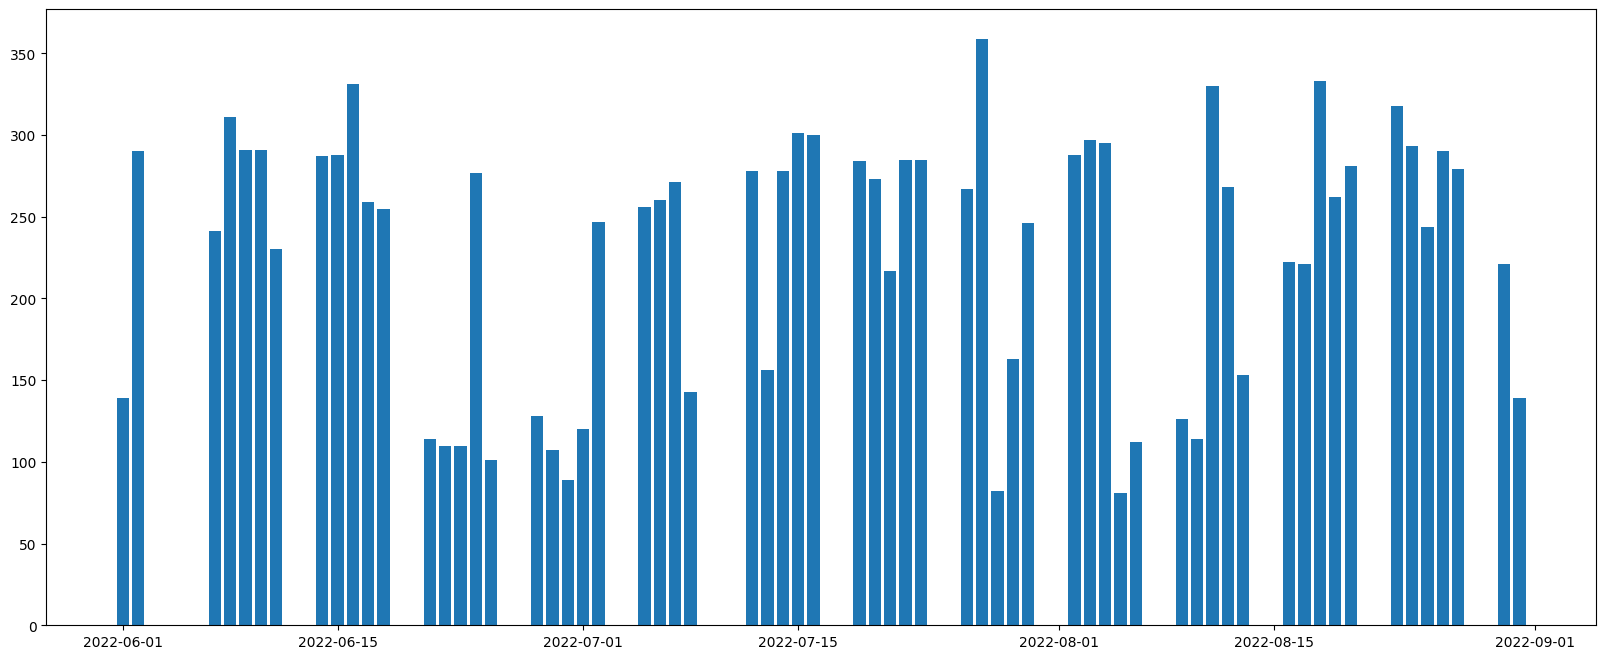

In [9]:
# volumes_totais_diarios['Volume'].plot(kind='bar', figsize = (15,8));
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])

## Media Movel

### Escolhendo melhor numero de janela para a media movel (baseado no erro)

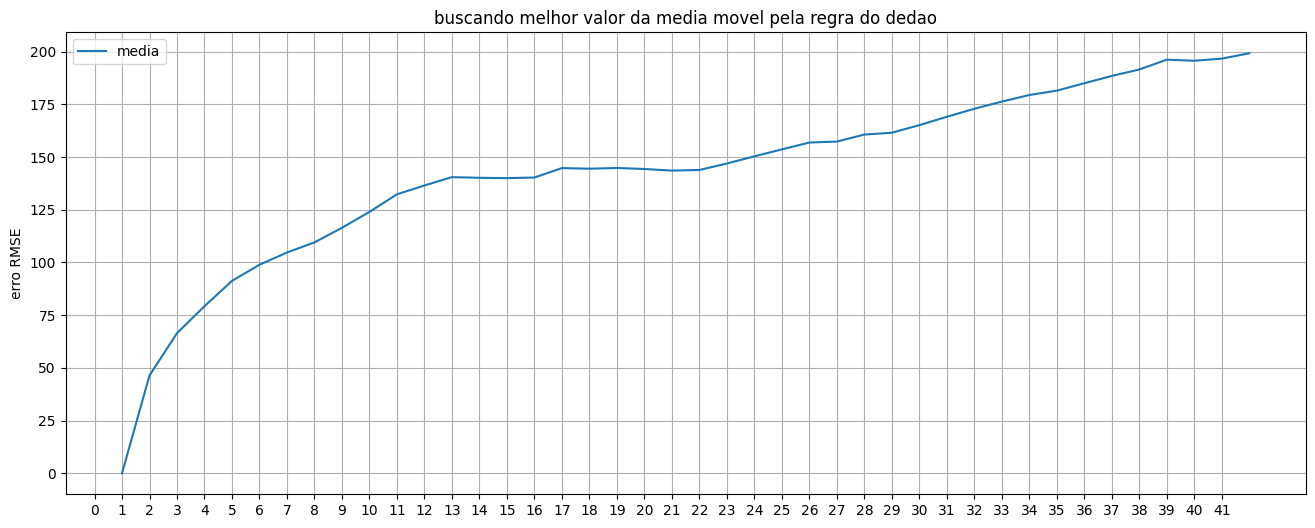

In [10]:
plt.rcParams["figure.figsize"] = (16,6)

erros_MA_diario = moving_average_test(volumes_totais_diarios)

plt.plot(erros_MA_diario.n_window, erros_MA_diario.RMSE)
plt.xticks([i for i in range(erros_MA_diario.shape[0])])
plt.legend(loc= 'best',labels = ['media', 'mediana'])
plt.ylabel('erro RMSE')
plt.title('buscando melhor valor da media movel pela regra do dedao')
plt.grid(visible=True, which = 'both')

plt.show()



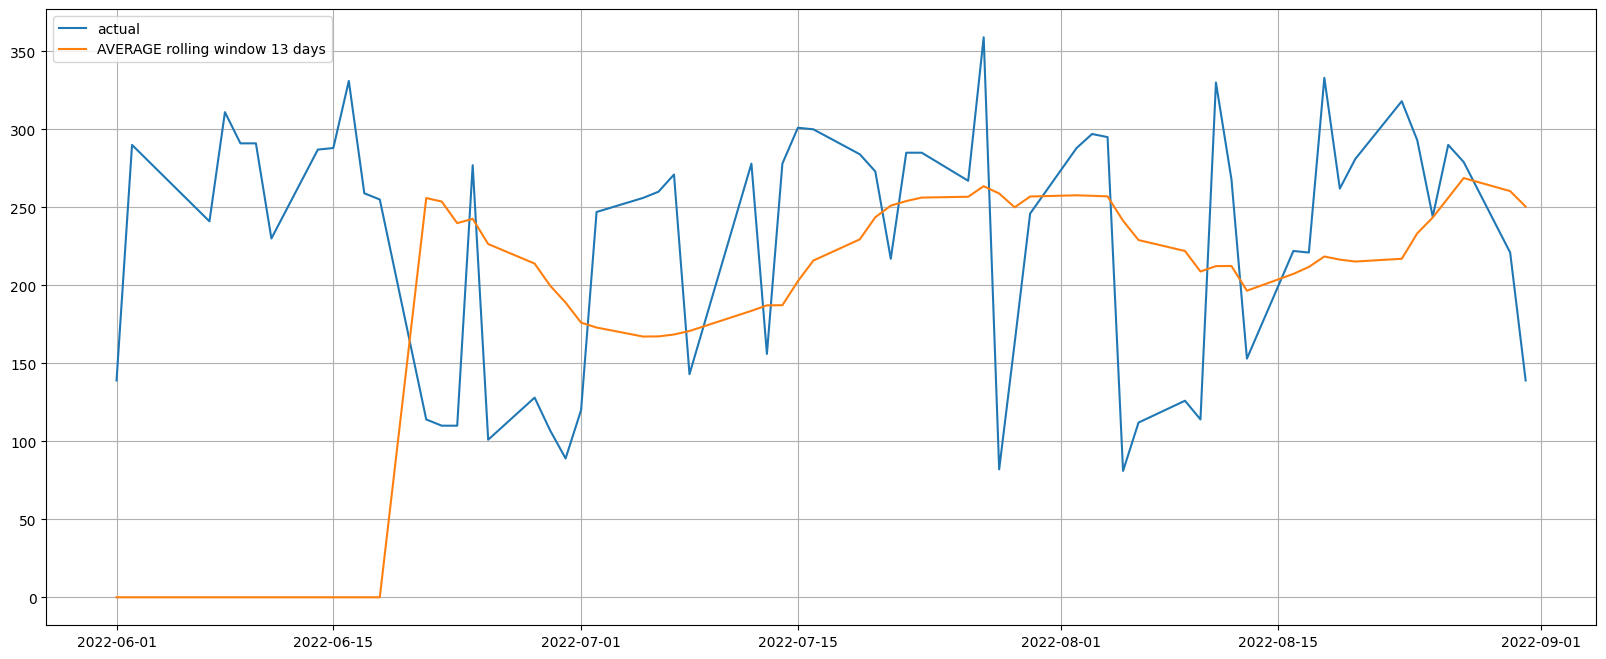

In [11]:
parametro = 13

volumes_totais_diarios['media_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).mean().fillna(0)
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])
plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['media_movel_' + str(parametro)])
plt.grid(visible=True)

# volumes_totais_diarios['mediana_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).median()
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['mediana_movel_' + str(parametro)], color = 'purple')

plt.legend(loc = 'upper left', labels = ['actual', 'AVERAGE rolling window {} days'.format(parametro), 'MEDIAN rolling window {} days'.format(parametro)])


plt.show()

### Modelagem Media Movel com step-by-step

In [12]:
volumes_totais_diarios

,Data,Volume,media_movel_13
0,2022-06-01,139,0.000000
1,2022-06-02,290,0.000000
2,2022-06-07,241,0.000000
3,2022-06-08,311,0.000000
4,2022-06-09,291,0.000000
...,...,...,...
58,2022-08-25,244,243.461538
59,2022-08-26,290,256.076923
60,2022-08-27,279,268.769231
61,2022-08-30,221,260.384615


In [13]:
results = list()
df_results_MA = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        MA_base = X['Volume'].rolling(13).mean().fillna(0)
        [results.append(MA_base.values[i]) for i in range(len(MA_base))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        MA_base = X['Volume'].rolling(13).mean().fillna(0)
        results.append(MA_base.values[-1])

df_results_MA = pd.concat([X[['Data','Volume']],pd.Series(results)], axis = 1, ignore_index = True)
df_results_MA.columns = ['Data', 'y_true', 'y_pred']
df_results_MA


,Data,y_true,y_pred
0,2022-06-01,139,0.000000
1,2022-06-02,290,0.000000
2,2022-06-07,241,0.000000
3,2022-06-08,311,0.000000
4,2022-06-09,291,0.000000
...,...,...,...
58,2022-08-25,244,243.461538
59,2022-08-26,290,256.076923
60,2022-08-27,279,268.769231
61,2022-08-30,221,260.384615


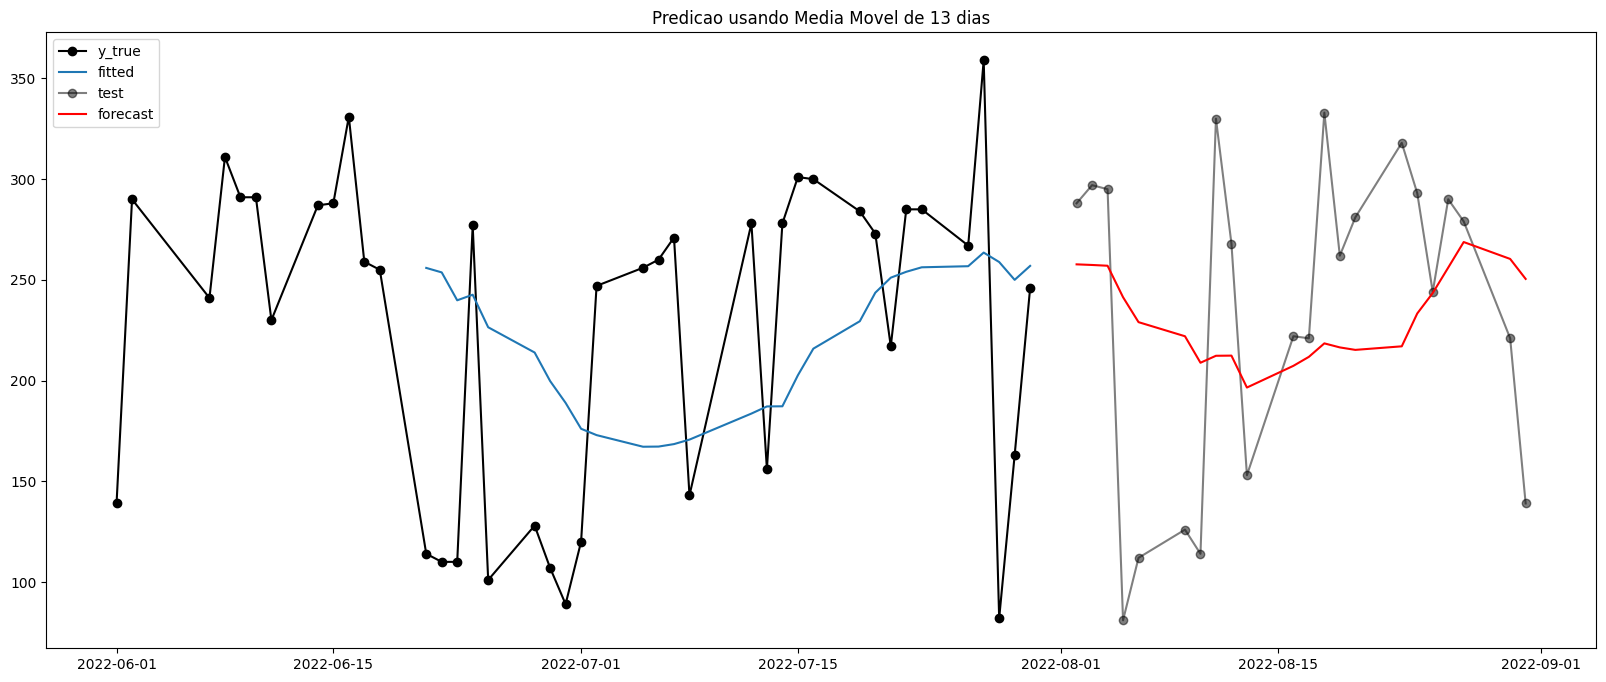

In [14]:
plt.rcParams["figure.figsize"] = (20,8)

# actual values
plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

# result of trained values
plt.plot(X_train['Data'][12:41],df_results_MA['y_pred'][12:41])

# actual future values
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

# predicted values
plt.plot(X_test['Data'],df_results_MA['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])
plt.title('Predicao usando Media Movel de 13 dias')

plt.show()

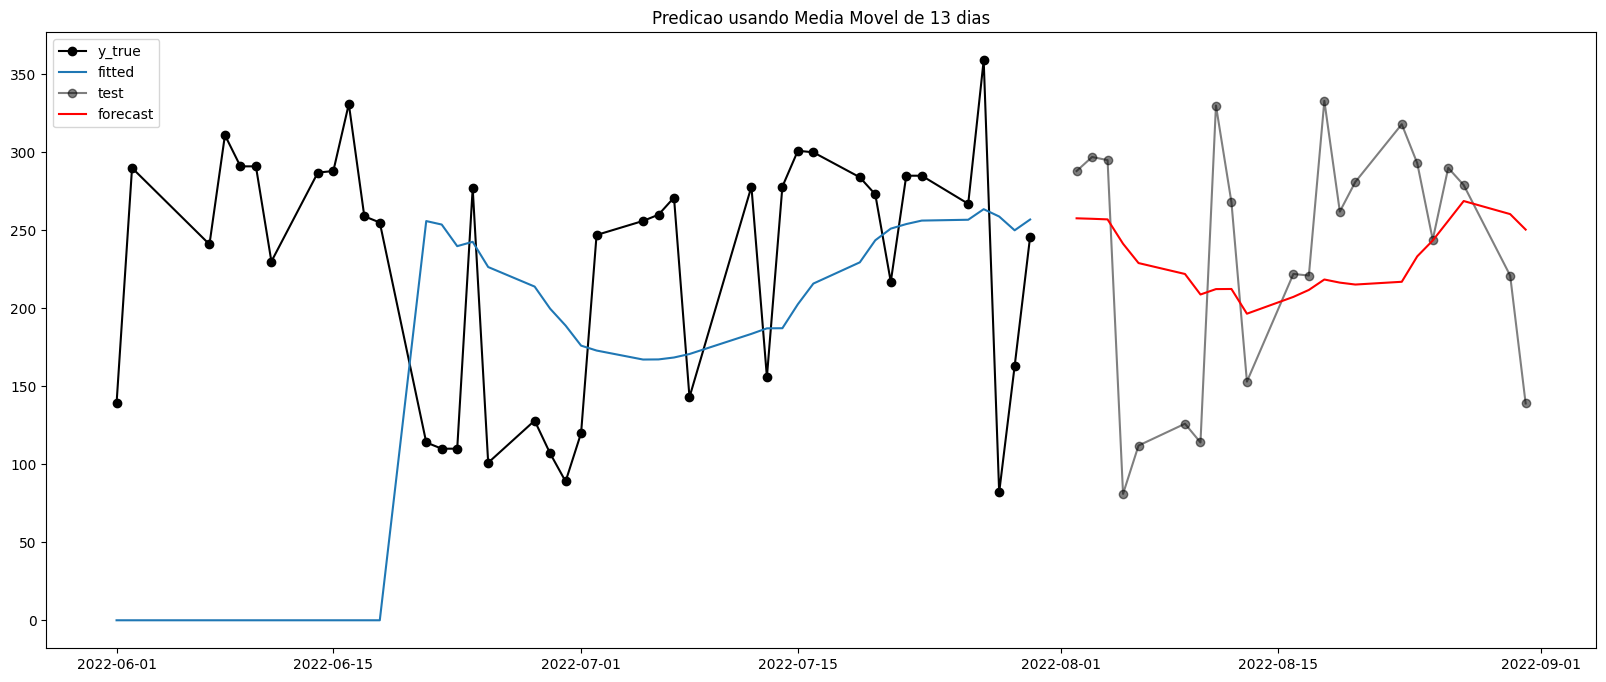

In [15]:
plt.rcParams["figure.figsize"] = (20,8)

# actual values
plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

# result of trained values
plt.plot(X_train['Data'][:41],df_results_MA['y_pred'][:41])

# actual future values
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

# predicted values
plt.plot(X_test['Data'],df_results_MA['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])
plt.title('Predicao usando Media Movel de 13 dias')

plt.show()

### calculo do erro

In [16]:
print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_MA['y_true'][41:],
                            df_results_MA['y_pred'][41:],
                            squared=False))

erro (RMSE) da previsao 	 76.63677664955641


## Suavizacao Exponencial com step-by-step


[217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918]


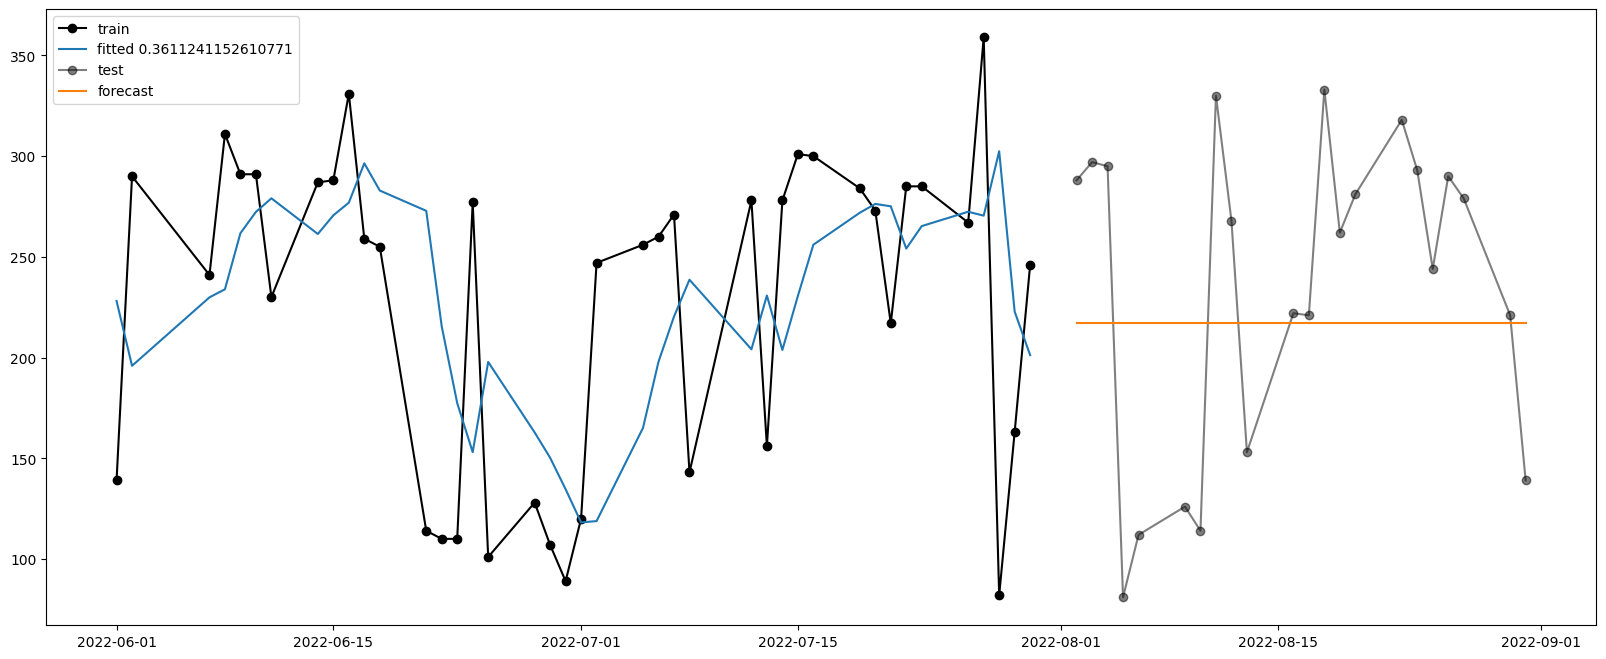

In [17]:
plt.figure(figsize=(20, 8))

fit1 = SimpleExpSmoothing(X_train['Volume'].values, initialization_method="heuristic").fit()

plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")
plt.plot(X_train['Data'],fit1.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],fit1.forecast(22))
print(fit1.forecast(23))

plt.legend(loc = 'upper left', labels = ['train', 'fitted {}'.format(fit1.model.params["smoothing_level"]), 'test', 'forecast'])

plt.show();

In [18]:
results = list()
df_results_SES = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        SES_base = SimpleExpSmoothing(X['Volume'].values, initialization_method="heuristic").fit()
        [results.append(SES_base.fittedvalues[i]) for i in range(len(SES_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        SES_step = SimpleExpSmoothing(X['Volume'].values, initialization_method="heuristic").fit(smoothing_level=SES_base.model.params["smoothing_level"])
        results.append(SES_step.fittedvalues[-1])

df_results_SES = pd.concat([X[['Data','Volume']],pd.Series(results)], axis = 1, ignore_index = True)
df_results_SES.columns = ['Data', 'y_true', 'y_pred']
print('smoothing_level =',SES_base.model.params["smoothing_level"])
df_results_SES


smoothing_level = 0.3611241152610771


,Data,y_true,y_pred
0,2022-06-01,139,228.086272
1,2022-06-02,290,195.915071
2,2022-06-07,241,229.891408
3,2022-06-08,311,233.902988
4,2022-06-09,291,261.744578
...,...,...,...
58,2022-08-25,244,288.032849
59,2022-08-26,290,272.131525
60,2022-08-27,279,278.584262
61,2022-08-30,221,278.734395


## Metodo de Holt

### Sem step-by-step

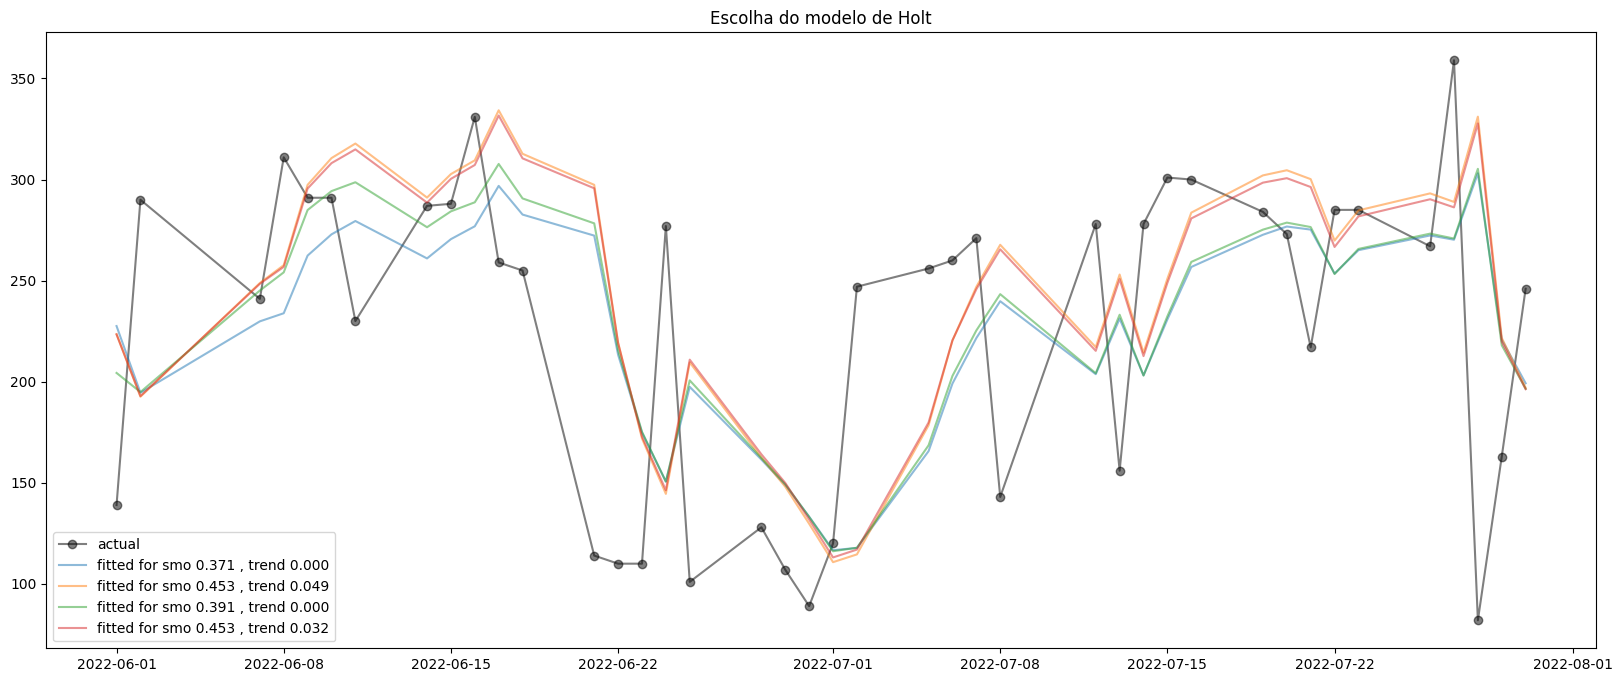

In [19]:
plt.figure(figsize=(20, 8))

fit_holts1 = Holt(X_train['Volume'].values, initialization_method="estimated").fit(optimized=True)

fit_holts2 = Holt(X_train['Volume'].values, exponential=True, initialization_method="estimated").fit(optimized=True)

fit_holts3 = Holt(X_train['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

fit_holts4 = Holt(X_train['Volume'].values,exponential=True, damped_trend=True, initialization_method="estimated").fit(optimized=True)

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)

plt.plot(X_train['Data'],fit_holts1.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts2.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts3.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts4.fittedvalues,   alpha = 0.5)

plt.legend(loc = 'lower left', labels = ['actual', 
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts1.model.params["smoothing_level"], fit_holts1.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts2.model.params["smoothing_level"], fit_holts2.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts3.model.params["smoothing_level"], fit_holts3.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts4.model.params["smoothing_level"], fit_holts4.model.params["smoothing_trend"])
                                
                                ])

plt.title('Escolha do modelo de Holt')

plt.show();

In [20]:
print('exponential, Type of trend component.', end= '\n')
print('damped_trend, Should the trend component be damped.', end= '\n')
print()
print('erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)\t', mean_squared_error(X_train['Volume'],fit_holts1.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)\t', mean_squared_error(X_train['Volume'],fit_holts2.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)\t', mean_squared_error(X_train['Volume'],fit_holts3.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True e damped_trend=True)\t', mean_squared_error(X_train['Volume'],fit_holts4.fittedvalues, squared=False))


print('\n ------> a melhor modelagem eh (fit otimizado = otimos / damped_trend=True)' )
 

exponential, Type of trend component.
damped_trend, Should the trend component be damped.

erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 75.54369280073026
erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)	 80.23092596189554
erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)	 75.12564422984332
erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True e damped_trend=True)	 79.46778300635756

 ------> a melhor modelagem eh (fit otimizado = otimos / damped_trend=True)


[215.84316727 215.83677142 215.83158247 215.82737266 215.82395724
 215.8211863  215.81893824 215.81711438 215.81563468 215.81443419
 215.81346024 215.81267007 215.81202901 215.81150891 215.81108695
 215.81074462 215.81046688 215.81024155 215.81005875 215.80991043
 215.80979011 215.80969249]


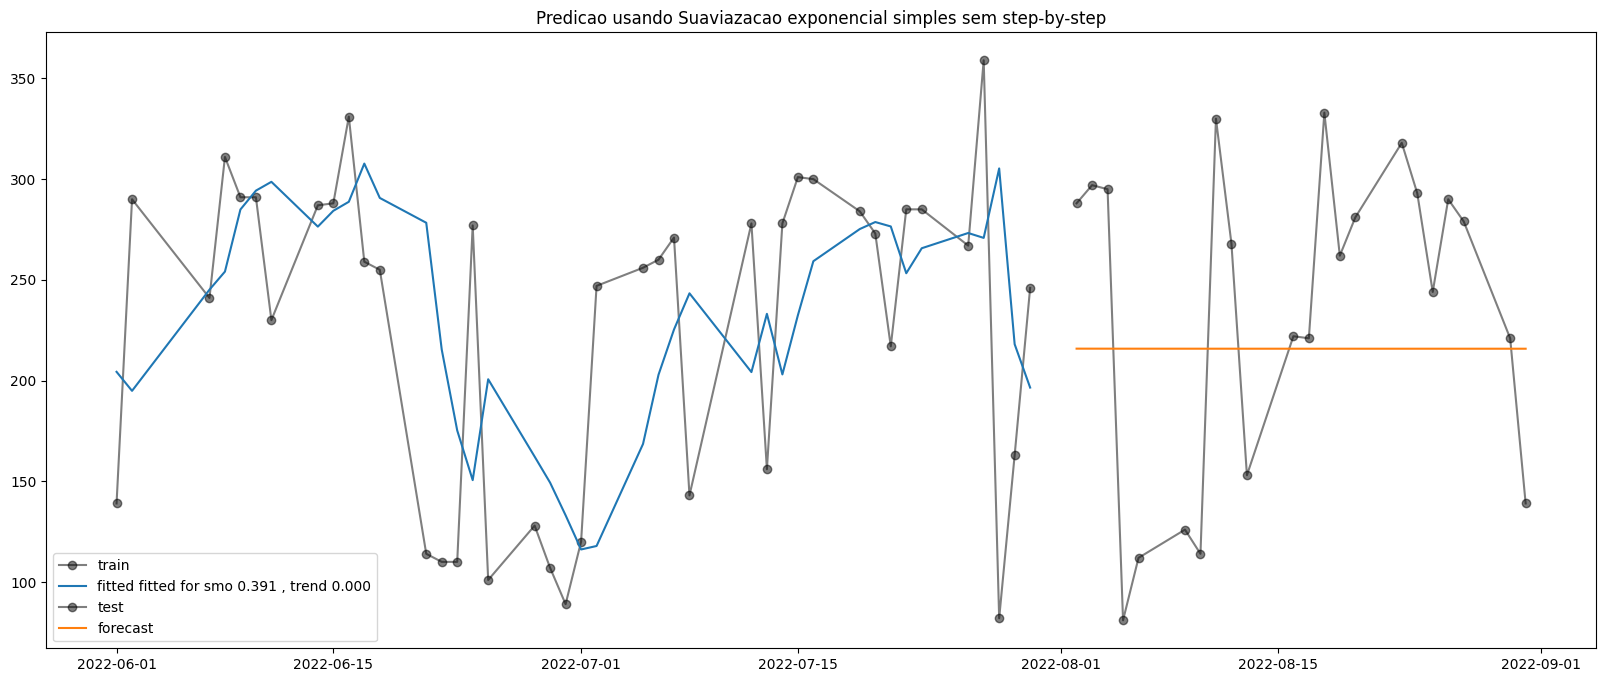

In [21]:
plt.figure(figsize=(20, 8))

fit_holts_final = Holt(X_train['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)
plt.plot(X_train['Data'],fit_holts_final.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],fit_holts_final.forecast(22))
print(fit_holts_final.forecast(22))

plt.legend(loc = 'lower left', labels = ['train',
                    'fitted {}'.format('fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts_final.model.params["smoothing_level"], fit_holts_final.model.params["smoothing_trend"])),
                    'test', 'forecast'])

plt.title('Predicao usando Suaviazacao exponencial simples sem step-by-step')

plt.show();


### Com step-by-step

In [22]:
results = list()
df_results_SEH = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        SEH_base = Holt(X['Volume'].values, damped_trend=True, initialization_method="estimated").fit()
        [results.append(SEH_base.fittedvalues[i]) for i in range(len(SEH_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        SEH_step = Holt(X['Volume'].values, damped_trend=True, initialization_method="estimated").fit(smoothing_level = SEH_base.model.params["smoothing_level"],
                                                                                                      smoothing_trend = SEH_base.model.params["smoothing_trend"]  )
        results.append(SEH_step.fittedvalues[-1])

df_results_SEH = pd.concat([X[['Data','Volume']],pd.Series(results)], axis = 1, ignore_index = True)

df_results_SEH.columns = ['Data', 'y_true', 'y_pred']
print('smoothing_level =',SEH_base.model.params["smoothing_level"])
print('smoothing_trend =',SEH_base.model.params["smoothing_trend"])
df_results_SEH


smoothing_level = 0.39070768848951115
smoothing_trend = 0.00047258699411787975


,Data,y_true,y_pred
0,2022-06-01,139,204.342813
1,2022-06-02,290,194.891503
2,2022-06-07,241,245.109988
3,2022-06-08,311,254.098244
4,2022-06-09,291,284.933698
...,...,...,...
58,2022-08-25,244,291.748919
59,2022-08-26,290,273.971567
60,2022-08-27,279,280.956831
61,2022-08-30,221,280.181379


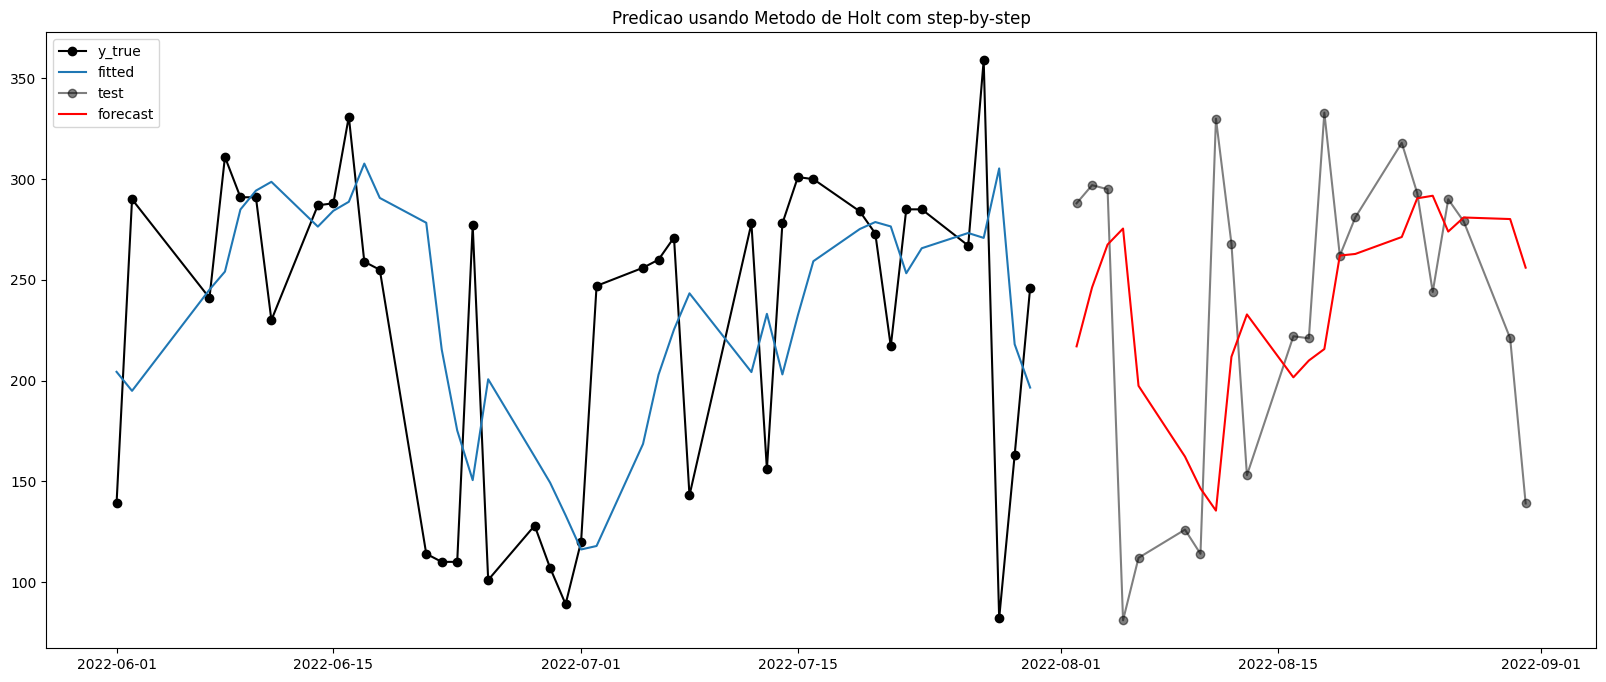

In [23]:
plt.figure(figsize=(20, 8))

plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

plt.plot(X_train['Data'],df_results_SEH['y_pred'][:41])

plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

plt.plot(X_test['Data'],df_results_SEH['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])

plt.title('Predicao usando Metodo de Holt com step-by-step')

plt.show();

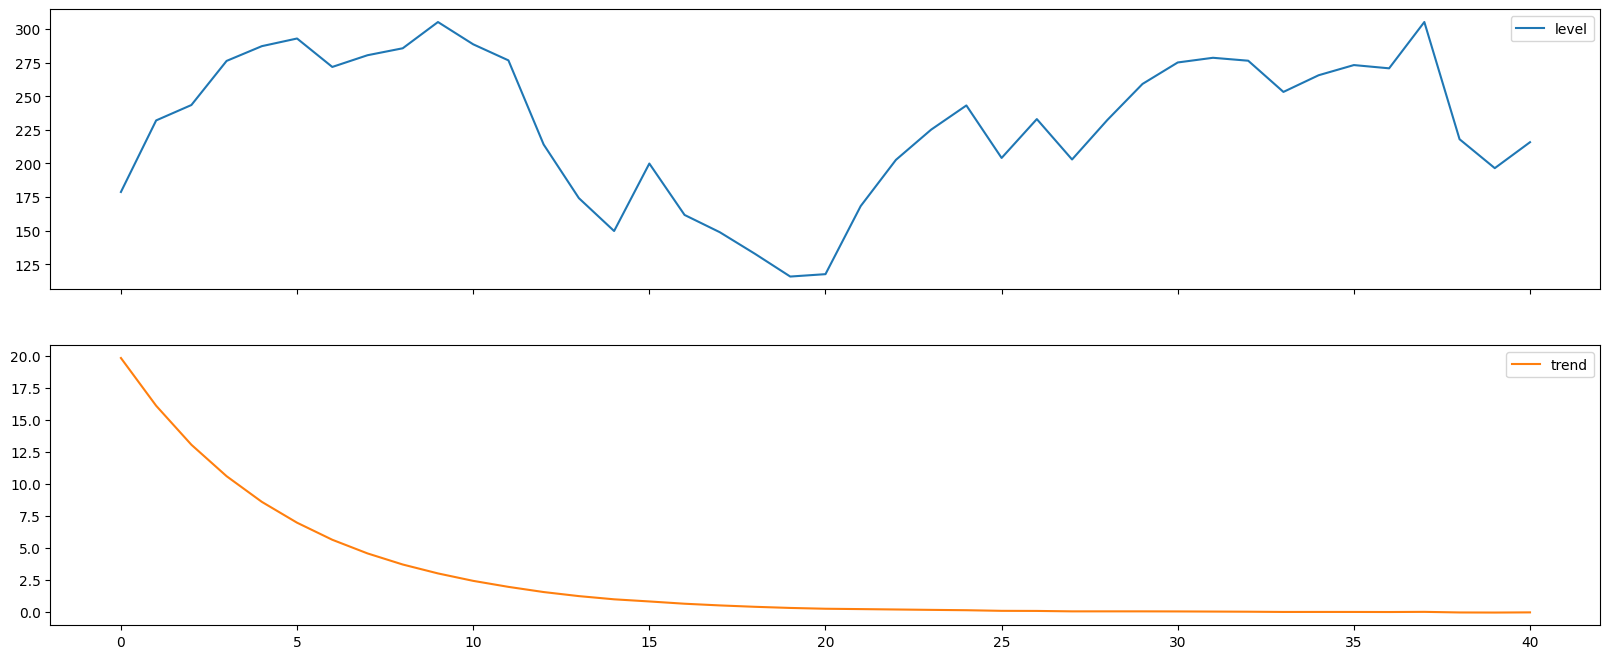

In [24]:
pd.DataFrame(np.c_[SEH_base.level, SEH_base.trend]).rename(
    columns={0: "level", 1: "trend"}
).plot(subplots=True)

plt.show()


#### como calcular o erro do metodo de holt?

O metodo de holts tem 2 hyperparametros serem ajustados, mas tambem uma serie de metodos de calculo que variam os resultados
 - exponential=True
 - damped_trend=True
 - entre outros 

In [25]:
# print('erro (RMSE) da modelagem \t',
#          mean_squared_error(df_results_SEH['y_true'][:41],
#                             df_results_SEH['y_pred'][:41],
#                             squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_SEH['y_true'][41:],
                            df_results_SEH['y_pred'][41:],
                            squared=False))

erro (RMSE) da previsao 	 79.71815394184111


## Metodo de Holt Winters

### escolha dos parametros

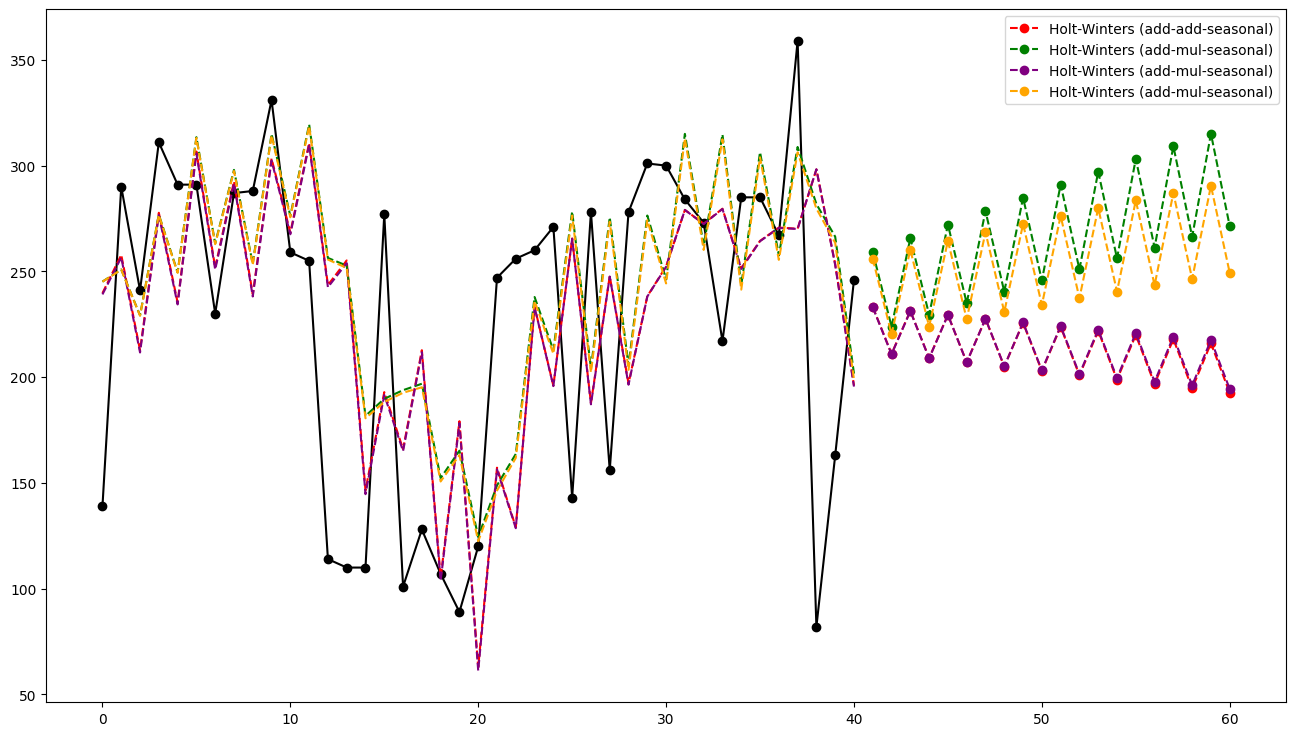

melhor desempenho fica com multiplicative HW damped, mas por muito pouco


,Additive,Multiplicative,Additive Dam,Multiplicative Dam
$\alpha$,0.322612,0.358571,0.325207,0.358571
$\beta$,0.000700,0.000100,0.000100,0.000100
$\phi$,NaN,NaN,0.989440,0.990000
$\gamma$,0.088190,0.000100,0.087757,0.000100
$l_0$,5746.920811,5754.481867,5742.590067,5754.481867
$b_0$,-30.838784,104.571160,-48.119789,104.571160
RMSE,76.192592,75.694386,76.175591,75.415384


In [26]:
HW1 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="add",use_boxcox=True,initialization_method="estimated").fit()
HW2 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit()
HW3 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="add",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()
HW4 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()

erros_HW = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "RMSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
erros_HW["Additive"] = [HW1.params[p] for p in params] +            [mean_squared_error(X_train['Volume'],HW1.fittedvalues, squared=False)]
erros_HW["Multiplicative"] = [HW2.params[p] for p in params] +      [mean_squared_error(X_train['Volume'],HW2.fittedvalues, squared=False)]
erros_HW["Additive Dam"] = [HW3.params[p] for p in params] +        [mean_squared_error(X_train['Volume'],HW3.fittedvalues, squared=False)]
erros_HW["Multiplicative Dam"] = [HW4.params[p] for p in params] +  [mean_squared_error(X_train['Volume'],HW4.fittedvalues, squared=False)]

ax = X_train['Volume'].plot(figsize=(16, 9),marker="o",color="black")

HW1.fittedvalues.plot(ax=ax, style="--", color = 'red')
HW2.fittedvalues.plot(ax=ax, style="--", color = 'green')
HW3.fittedvalues.plot(ax=ax, style="--", color = 'purple')
HW4.fittedvalues.plot(ax=ax, style="--", color = 'orange')

HW1.forecast(20).rename("Holt-Winters (add-add-seasonal)").plot(ax=ax, style="--", marker="o", color="red", legend=True)
HW2.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="green", legend=True)
HW3.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="purple", legend=True)
HW4.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="orange", legend=True)

plt.show()
print('melhor desempenho fica com multiplicative HW damped, mas por muito pouco')

erros_HW

### modelagem

41    255.974064
42    220.289746
43    260.272172
44    223.901717
45    264.440993
46    227.405882
47    268.486324
48    230.807006
49    272.413546
50    234.109520
51    276.227672
52    237.317552
53    279.933377
54    240.434964
55    283.535039
56    243.465368
57    287.036760
58    246.412158
59    290.442392
60    249.278523
61    293.755564
62    252.067468
63    296.979695
dtype: float64


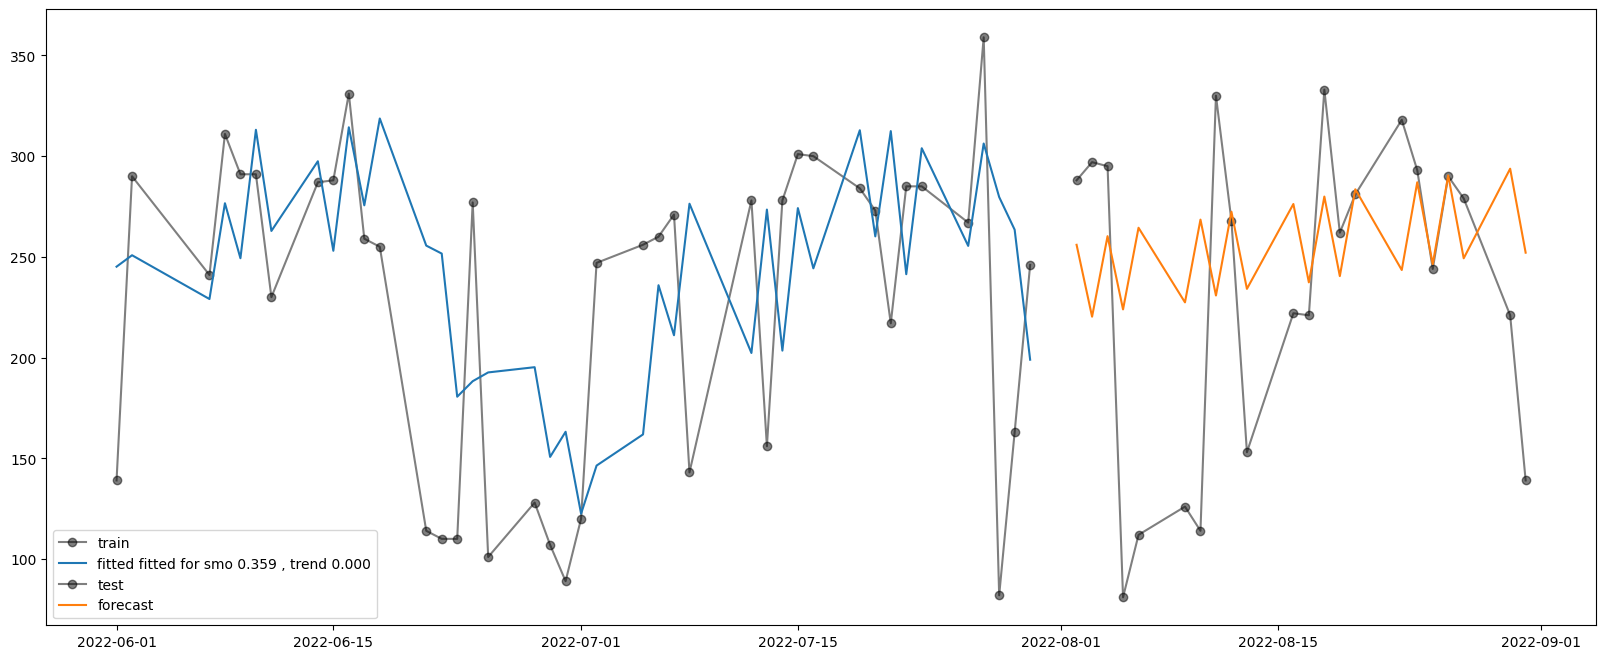

In [27]:
plt.figure(figsize=(20, 8))

HW4 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)
plt.plot(X_train['Data'],HW4.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],HW4.forecast(22))
print(HW4.forecast(23))

plt.legend(loc = 'lower left', labels = ['train',
                    'fitted {}'.format('fitted for smo {:.3f} , trend {:.3f}'.format(HW4.model.params["smoothing_level"], HW4.model.params["smoothing_trend"])),
                    'test', 'forecast'])

plt.show();


In [28]:
results = list()
df_results_HW = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        HW_base = ExponentialSmoothing( X['Volume'],
                                        seasonal_periods=2,
                                        trend="add",
                                        seasonal="mul",
                                        damped_trend=True,
                                        use_boxcox=True,
                                        initialization_method="estimated").fit(optimized = True)
        [results.append(HW_base.fittedvalues[i]) for i in range(len(HW_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        HW_step = ExponentialSmoothing( X['Volume'],
                                        seasonal_periods=2,
                                        trend="add",
                                        seasonal="mul",
                                        damped_trend=True,
                                        use_boxcox=True,
                                        initialization_method="estimated").fit( smoothing_level = HW_base.model.params["smoothing_level"],
                                                                                smoothing_trend = HW_base.model.params["smoothing_trend"],
                                                                                optimized = True  )
        results.append(HW_step.fittedvalues[i-1])


df_results_HW = pd.concat([X[['Data','Volume']],pd.Series(results)], axis = 1, ignore_index = True)
df_results_HW.columns = ['Data', 'y_true', 'y_pred']
print('smoothing_level =',HW_base.model.params["smoothing_level"])
print('smoothing_trend =',HW_base.model.params["smoothing_trend"])
df_results_HW


smoothing_level = 0.3585714285714286
smoothing_trend = 0.0001


,Data,y_true,y_pred
0,2022-06-01,139,245.124220
1,2022-06-02,290,250.798220
2,2022-06-07,241,229.060573
3,2022-06-08,311,276.613323
4,2022-06-09,291,249.309686
...,...,...,...
58,2022-08-25,244,270.565838
59,2022-08-26,290,302.865049
60,2022-08-27,279,260.191603
61,2022-08-30,221,309.298047


In [29]:
df_results_HW[38:45]

,Data,y_true,y_pred
38,2022-07-28,82,279.695134
39,2022-07-29,163,263.478878
40,2022-07-30,246,198.938469
41,2022-08-02,288,255.929700
42,2022-08-03,297,232.443258
43,2022-08-04,295,301.567929
44,2022-08-05,81,258.578587


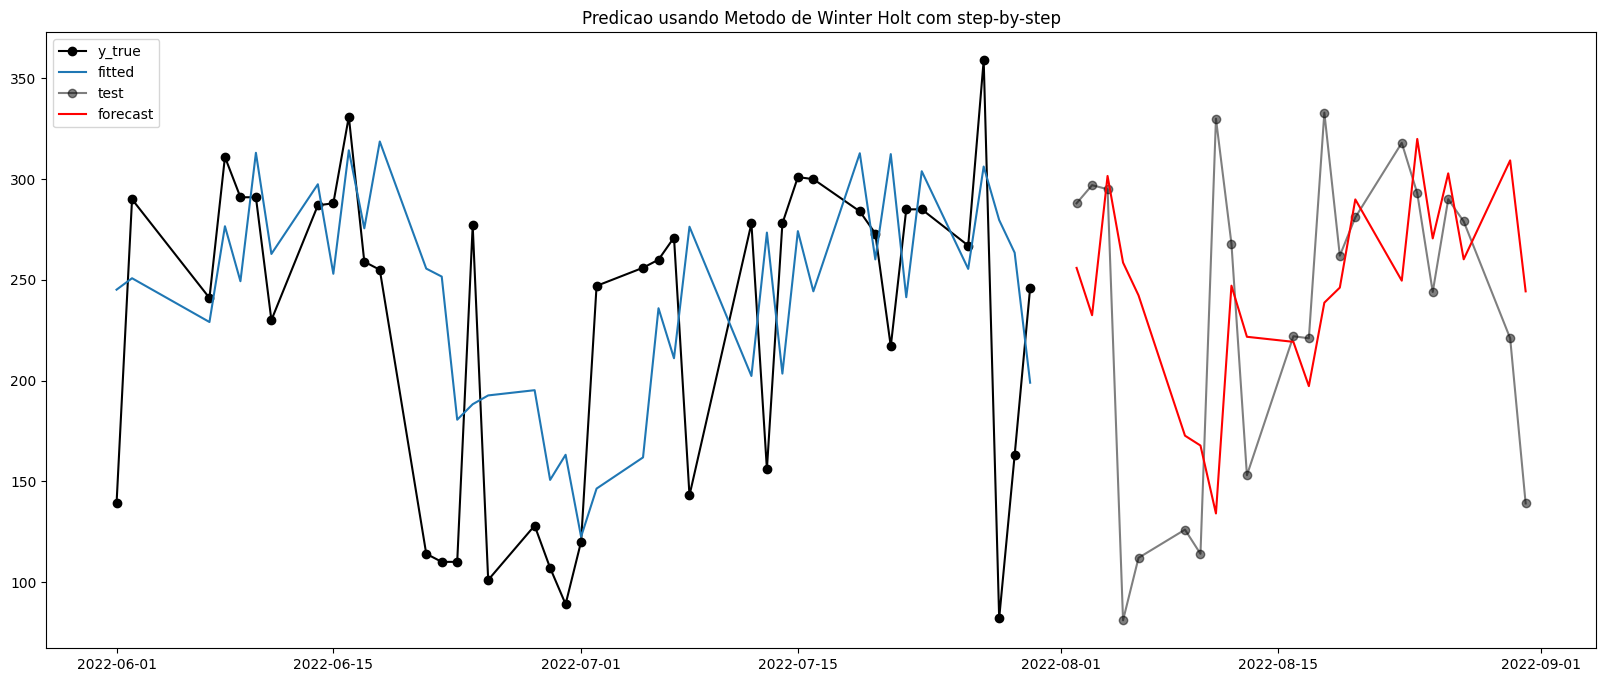

In [30]:
plt.figure(figsize=(20, 8))

######## y_pred[:41] deve ser igual ao fit1.fittedvalues E O FATO SE CONFIRMA COM O CODIGO ABAIXO

# fit1 = SimpleExpSmoothing(X_train['Volume'].values, initialization_method="heuristic").fit()
# plt.plot(X_train['Data'],fit1.fittedvalues, color = 'pink')


plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

plt.plot(X_train['Data'],df_results_HW['y_pred'][:41])

plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

plt.plot(X_test['Data'],df_results_HW['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])

plt.title('Predicao usando Metodo de Winter Holt com step-by-step')


plt.show();

In [31]:
# print('erro (RMSE) da modelagem \t',
#          mean_squared_error(df_results_HW['y_true'][:41],
#                             df_results_HW['y_pred'][:41],
#                             squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_HW['y_true'][41:],
                            df_results_HW['y_pred'][41:],
                            squared=False))

erro (RMSE) da previsao 	 79.11201113902855


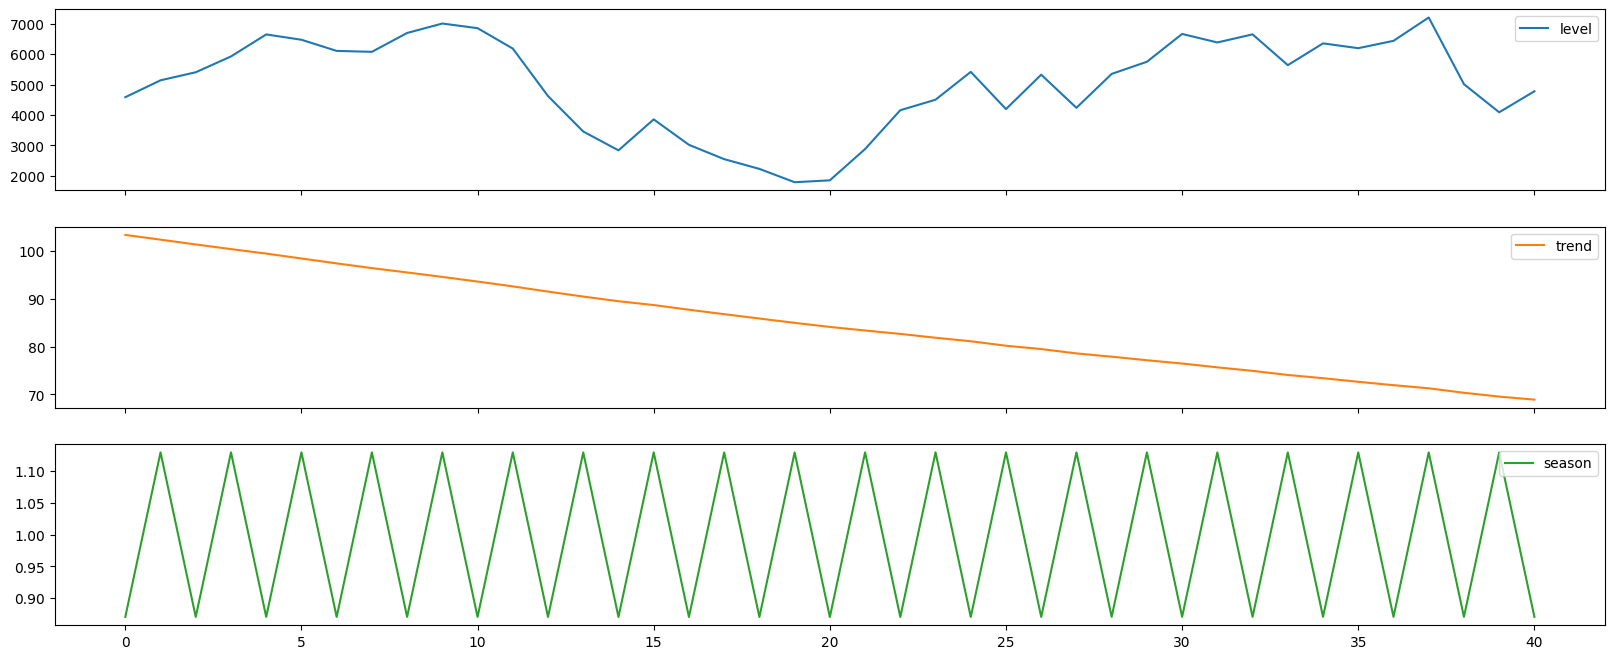

In [32]:
pd.DataFrame(np.c_[HW_base.level, HW_base.trend, HW_base.season]).rename(
    columns={0: "level", 1: "trend", 2:"season"}
).plot(subplots=True)
plt.show()


## ARIMA

### Determinação dos parâmetros do ARIMA

#### Checar se a série é estacionária
A série estacionária é condição _sine qua non_ para a aplicação do método; caso nao for, é possível utilizar a diferenciação da série - quantas vezes forem necessárias -  para torná-la estacionária. Escolhido o radar, observa-se se a série pode ser considerada estacionária (p-value inferior a 0.05) por meio do teste de Dickey-Fuller aumentado (ADF).

In [33]:
result_adfuller = adfuller(X_train.Volume)
print('ADF Statistic: %f' % result_adfuller[0])
print('p-value: %f' % result_adfuller[1])

ADF Statistic: -4.331597
p-value: 0.000391


#### Validação Visual

Para validar visualmente o resultado do teste ADF, plotamos funções de autocorrelação para a série original, com diferenciação de primeira e de segunda ordem. 

Espera-se que a série original tenha uma curva da Função de Autocorrelação (ACF) decrescente enquanto as outras possuam uma queda abrupta pois, segundo o teste ADF, elas já serão diferenciadas.

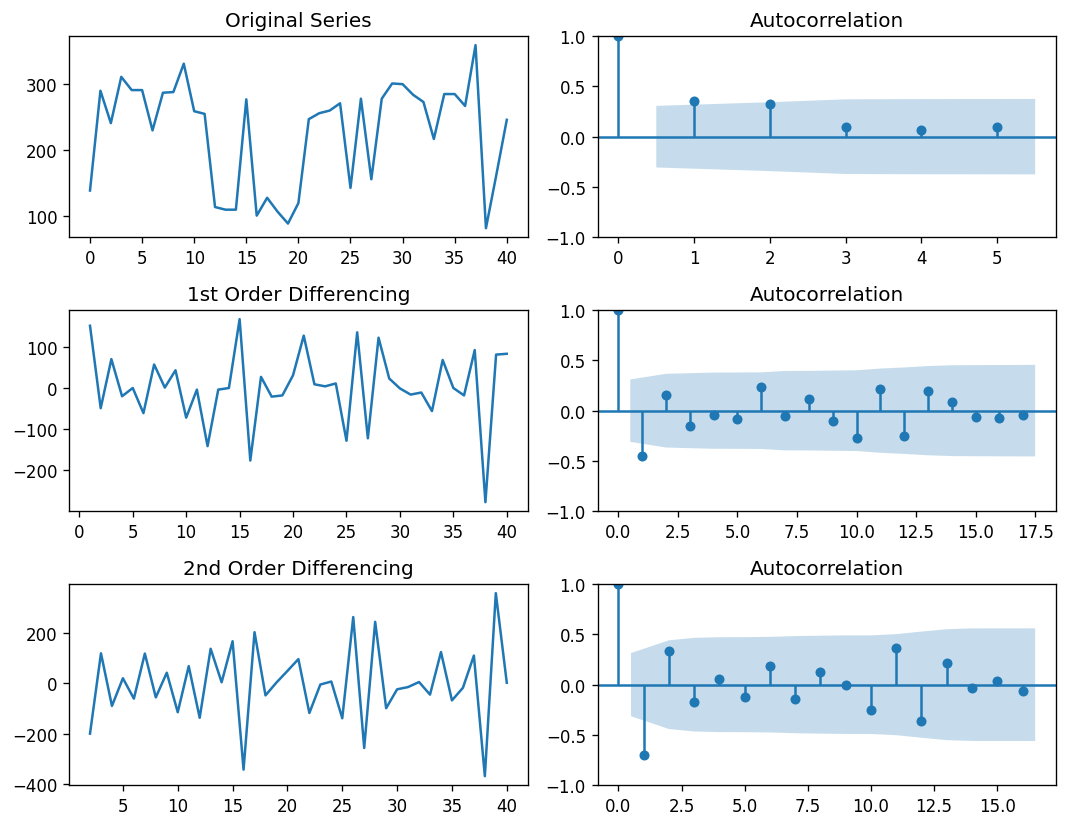

In [34]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=False)

# Original Series
axes[0, 0].plot(X_train.Volume); axes[0, 0].set_title('Original Series')
plot_acf(X_train.Volume, ax=axes[0, 1], alpha=0.05, lags=5)

# 1st Differencing
axes[1, 0].plot(X_train.Volume.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train.Volume.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train.Volume.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train.Volume.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

Os graficos mostram que na primeira diferenciação a série já se torna super diferenciada (o que pode ser notado pela queda abrupta na curva de autocorrelação). Isso indica que o parâmetro d=1 é o ideal

#### Ordem da Auto-Regressão

Por se tratar de uma regressão feita sobre os valores anteriores da série vale conferir até que ponto há correlação entre os pontos de observação. Isso é definido através da Função de Autocorrelação Parcial (PACF).

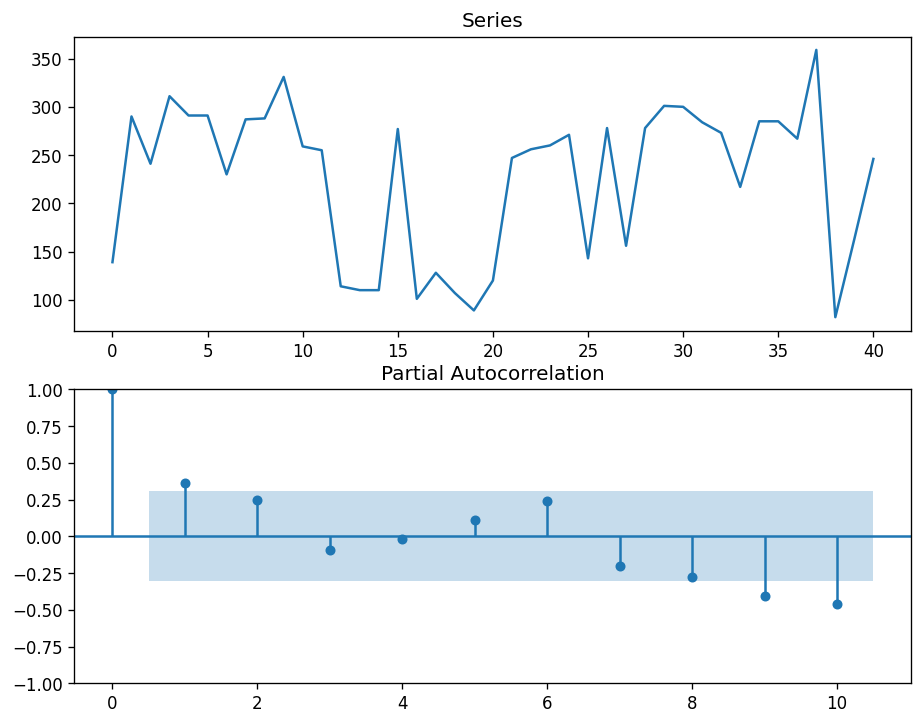

In [35]:
# PACF
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].plot(X_train.Volume); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.5))
plot_pacf(X_train.Volume, ax=axes[1], lags= 10)

plt.show()

#### Ordem da Média-Móvel

O plot da ACF fornece um threshold, um limite, superior para o ordem do modelo MA. 

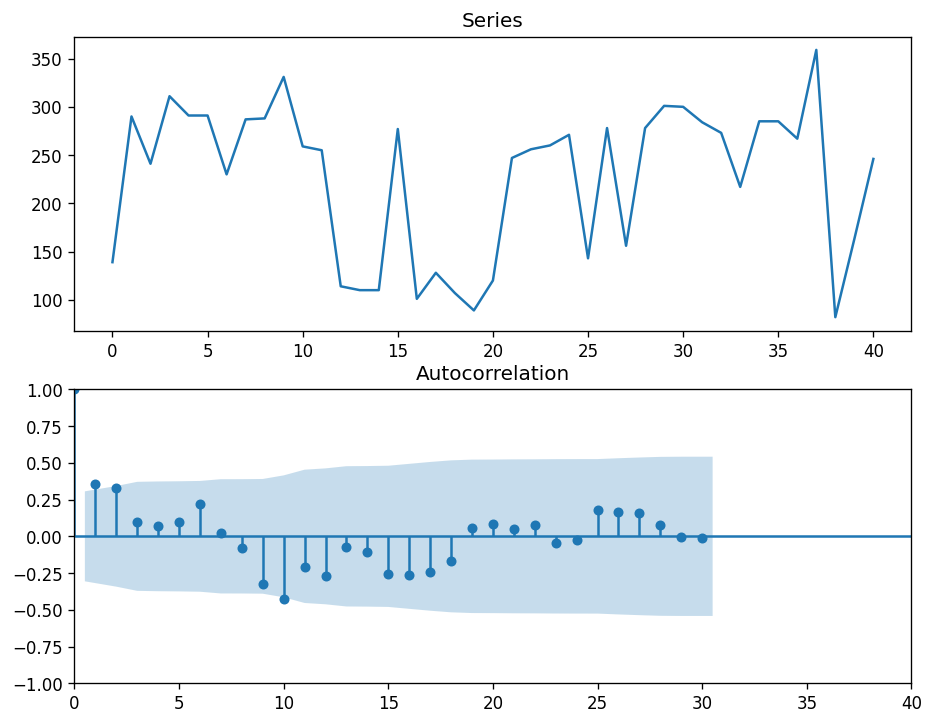

In [36]:
fig, axes = plt.subplots(2,1, sharex=False)


axes[0].plot(X_train.Volume); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.2), xlim=(0,40))
plot_acf(X_train.Volume, ax=axes[1], lags=30)


# plt.annotate('Entra na área de significância', xytext=(30, 1),xy=(43,0.4),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

A autocorrelação decai muito lentamente para a série em questão. 


Isso nos daria um treshold máximo da ordem de 40. No entanto, vale ressaltar que esse valor pode ser muito elevado, então deve-se sempre levar em conta tanto o fator de **performance do modelo** quanto **custo computacional**, evitando o uso de parâmetros muito elevados em quaisquer modelos.

Nos modelos ARIMA, a componente de média móvel raramente ultrapassa 3 ou 4. Por isso, utilizaremos o valor 2 para manter o modelo simples.

#### Modelagem

In [37]:
p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 2 #MediaMovel
# steps = 5 # Steps a serem previstos

# Instancia o modelo e faz o fit no treino
model = ARIMA(X_train['Volume'],order=(p,d,q)).fit()

# Realiza FORECAST
fc = model.predict(19, alpha=0.05)  # 95% conf


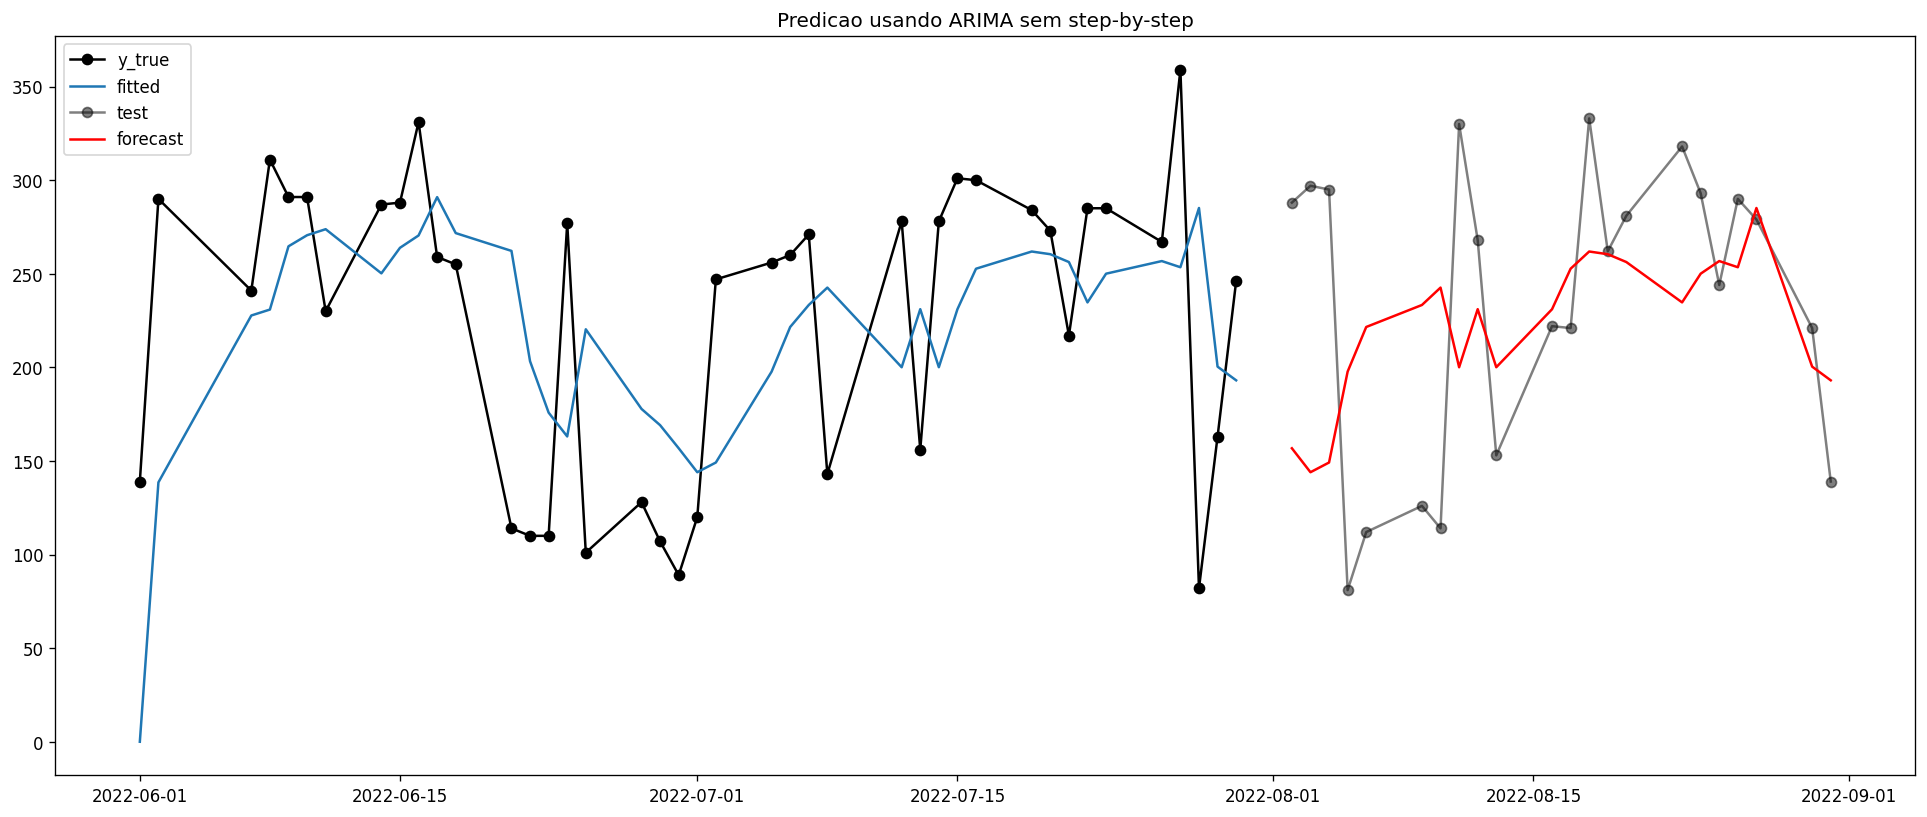

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

ax.plot(X_train['Data'],model.fittedvalues)

ax.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

ax.plot(X_test['Data'],fc, color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted','test', 'forecast'])

plt.title('Predicao usando ARIMA sem step-by-step')

plt.show()

In [39]:
results = list()
df_results_ARIMA = pd.DataFrame()

p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 2 #MediaMovel

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        ARIMA_base = ARIMA(X['Volume'],order=(p,d,q)).fit()
        
        [results.append(ARIMA_base.fittedvalues[i]) for i in range(len(ARIMA_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        ARIMA_step = ARIMA(X['Volume'],order=(p,d,q)).fit()
        results.append(ARIMA_step.fittedvalues[i-1])


df_results_ARIMA = pd.concat([X[['Data','Volume']],pd.Series(results)], axis = 1, ignore_index = True)
df_results_ARIMA.columns = ['Data', 'y_true', 'y_pred']
df_results_ARIMA


,Data,y_true,y_pred
0,2022-06-01,139,0.000000
1,2022-06-02,290,138.564249
2,2022-06-07,241,227.708662
3,2022-06-08,311,230.883287
4,2022-06-09,291,264.669057
...,...,...,...
58,2022-08-25,244,259.988788
59,2022-08-26,290,241.319108
60,2022-08-27,279,255.078532
61,2022-08-30,221,253.726913


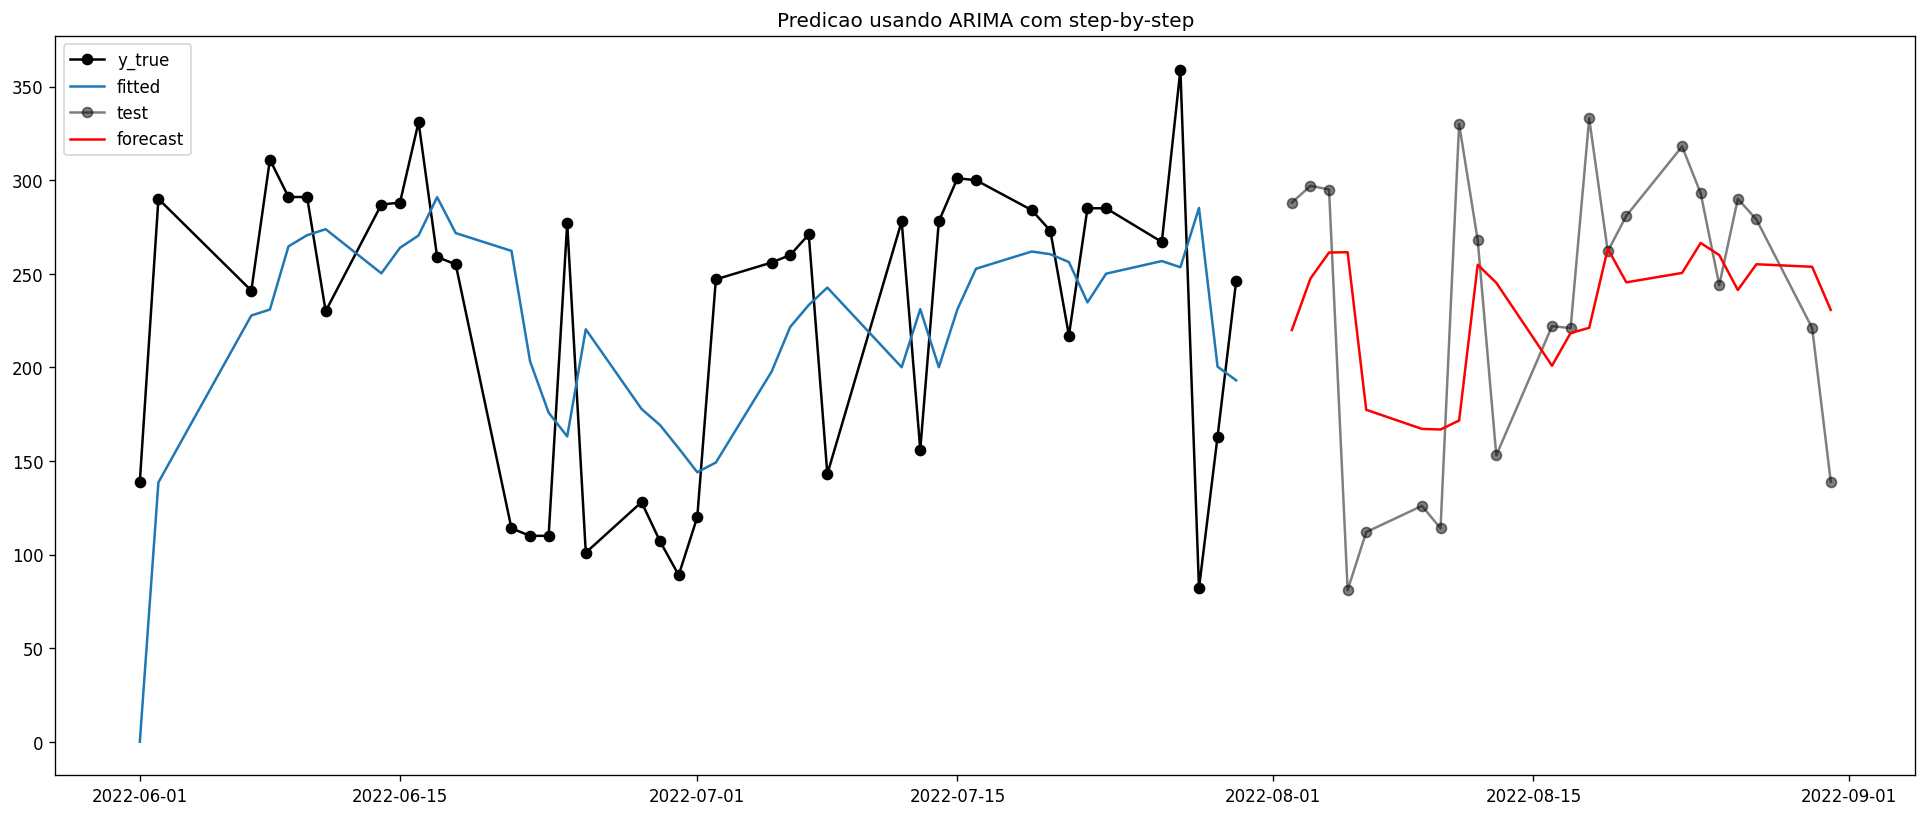

In [40]:
plt.figure(figsize=(20, 8))

plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

plt.plot(X_train['Data'],df_results_ARIMA['y_pred'][:41])

plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

plt.plot(X_test['Data'],df_results_ARIMA['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])

plt.title('Predicao usando ARIMA com step-by-step')


plt.show();

In [41]:
# print('erro (RMSE) da modelagem \t',
#          mean_squared_error(df_results_ARIMA['y_true'][:41],
#                             df_results_ARIMA['y_pred'][:41],
#                             squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_ARIMA['y_true'][41:],
                            df_results_ARIMA['y_pred'][41:],
                            squared=False))

erro (RMSE) da previsao 	 72.45417103424221


## Calculo dos erros

In [42]:
data = [{'ARIMA': mean_squared_error(df_results_ARIMA['y_true'][41:],df_results_ARIMA['y_pred'][41:],squared=False),\
        'MA13': mean_squared_error(df_results_MA['y_true'][41:],df_results_MA['y_pred'][41:],squared=False),\
        'SEH': mean_squared_error(df_results_SEH['y_true'][41:],df_results_SEH['y_pred'][41:],squared=False),\
        'SES': mean_squared_error(df_results_SES['y_true'][41:],df_results_SES['y_pred'][41:],squared=False),\
        'HW': mean_squared_error(df_results_HW['y_true'][41:],df_results_HW['y_pred'][41:],squared=False)},\

        {'ARIMA': mean_absolute_error(df_results_ARIMA['y_true'][41:],df_results_ARIMA['y_pred'][41:]),\
        'MA13': mean_absolute_error(df_results_MA['y_true'][41:],df_results_MA['y_pred'][41:] ),\
        'SEH': mean_absolute_error(df_results_SEH['y_true'][41:],df_results_SEH['y_pred'][41:]),\
        'SES': mean_absolute_error(df_results_SES['y_true'][41:],df_results_SES['y_pred'][41:]),\
        'HW': mean_absolute_error(df_results_HW['y_true'][41:],df_results_HW['y_pred'][41:]   )}]


erros = pd.DataFrame.from_records(data, index=['RMSE','MAE'])
erros


,ARIMA,MA13,SEH,SES,HW
RMSE,72.454171,76.636777,79.718154,80.286492,79.112011
MAE,56.112083,63.590909,58.483764,60.527667,58.630618


In [43]:
erros_scaled = erros.copy()

erros_scaled.loc['RMSE',:] = (erros.loc['RMSE',:]- erros.loc['RMSE',:].min() ) / (erros.loc['RMSE',:].max() - erros.loc['RMSE',:].min())

erros_scaled.loc['MAE',:] = (erros.loc['MAE',:]- erros.loc['MAE',:].min() ) / (erros.loc['MAE',:].max() - erros.loc['MAE',:].min())

erros_scaled


,ARIMA,MA13,SEH,SES,HW
RMSE,0.0,0.534019,0.927437,1.000000,0.850047
MAE,0.0,1.000000,0.317119,0.590411,0.336755


In [45]:
erros_min = erros.copy()

erros_min.loc['RMSE',:] = (erros.loc['RMSE',:] / erros.loc['RMSE',:].min() -1 ) *100
erros_min.loc['MAE',:] = (erros.loc['MAE',:] / erros.loc['MAE',:].min() -1 ) *100

erros_min


,ARIMA,MA13,SEH,SES,HW
RMSE,0.0,5.77276,10.025624,10.810034,9.189036
MAE,0.0,13.32837,4.226686,7.869221,4.488401


In [51]:
erros_viagens = erros/ viagens_validas.shape[0]
erros_viagens

,ARIMA,MA13,SEH,SES,HW
RMSE,0.005001,0.005290,0.005502,0.005542,0.005461
MAE,0.003873,0.004389,0.004037,0.004178,0.004047


In [53]:
# erros_viagens.to_excel('../Output de dados/erros_viagens_totais.xlsx')